In [1]:
using Statistics
using Printf
using Oceananigans
using ArgParse
using JLD2
using CairoMakie
###########-------- SIMULATION PARAMETERS ----------------#############

# curved topo parameters
const gausT_center = 895                                 # gaussian paramereters for curved "corner" of slope
const gausT_width = 180
const ySlopeSameˢ = 1332.22                           # point where planar and curved corner math up the best

sn = "U250N100Lz100g100"

include("../parameters.jl")

pm = getproperty(SimParams(), Symbol(sn))

resS = 1.0
dzr = pm.dz * resS
dhr = pm.dh * resS

pm = merge(pm, (; dzr=dzr, dhr=dhr, Tanθ = sqrt((pm.σ^2 - pm.f^2)/(pm.Ñ^2-pm.σ^2)),
                Tanα = pm.γ * sqrt((pm.σ^2 - pm.f^2)/(pm.Ñ^2-pm.σ^2)),
                nz = round(Int,pm.Lz/2), nx = round(Int, pm.Lx/dhr),
                m = π/pm.Lz,
                l = sqrt(((π/pm.Lz)^2 * (pm.f^2 - pm.σ^2)) / (pm.σ^2 - pm.Ñ^2)),
                Tf = 2*π/pm.f, 
                Tσ = 2*π/pm.σ))

# other params for setting up the grid
z_start = pm.Lz - pm.Lzˢ
Sp_extra = ifelse(z_start>0, 250.0, 0.0)
Ly = pm.Lyˢ+Sp_extra
ny = round(Int,Ly/pm.dhr)
slope_end = pm.Lzˢ/pm.Tanα

pm = merge(pm, (;Ly=Ly,ny=ny, slope_end=slope_end, Sp_extra=Sp_extra))

# if slope is in different spot than usual, need to move the curved part too!
const zSlopeSameˢ = -pm.Tanαˢ * ySlopeSameˢ
ySlopeSame = zSlopeSameˢ / -pm.Tanα
ΔySlopeSame = ySlopeSameˢ - ySlopeSame

@inline heaviside(X) = ifelse(X <0, 0.0, 1.0)
# exponential gaussian for curved corner
@inline expcurve(y, ystar, smo) = -pm.Lzˢ + pm.Lzˢ * exp(-(y-ystar)^2/(2*smo^2))
# planar slope line
@inline linslope(y) = -pm.Tanα*y
# combining the 2 with heaviside split at ySlopeSame
@inline curvedslope(y) = linslope(y) + (-linslope(y) + expcurve(y, gausT_center-ΔySlopeSame, gausT_width)) * heaviside(y-ySlopeSame)

curvedslope (generic function with 1 method)

In [2]:
# dye parameters
dye_height_orig = 20                               # height of initial dye
dye_centz = -250                                   # center z value for gaussian IC
dye_centy = dye_centz/-pm.Tanα

# along the slope
@inline dye(x, y, z, dH, sm, kt) = 0.5*( tanh( (dH-z) / sm ) + tanh(kt - z) )
# only dye in the fluid
@inline above_slope(y, z) = ifelse(z >= curvedslope(y), 1.0, 0.0)

# gaussian in center
@inline exparg(y, z, dh) = ((y - dye_centy)^2 + (z - dye_centz)^2) / (2*dh^2)
@inline dye_gauss(y, z, dh) = exp(-1.0 * exparg(y,z, dh))

# gaussian IC
cg(y, z, dh) = above_slope(y, z) * dye_gauss(y, z, dh) 

cg (generic function with 1 method)

In [84]:
4*20

80

In [29]:
δ = pm.U₀/pm.Ñ
[0.28 * δ, 0.15 * δ, 0.05 * δ, 0.40 * δ]

4-element Vector{Float64}:
 20.0
 10.714285714285712
  3.571428571428571
 28.57142857142857

In [17]:
zc = -499:2:0;
yc = 2:4:5000;

gauss_orig = [cg(y, z, dye_height_orig) for y in yc, z in zc];
gauss_15 = [cg(y, z, 0.15 * δ) for y in yc, z in zc];
gauss_05 = [cg(y, z, 0.05 * δ) for y in yc, z in zc];
gauss_40 = [cg(y, z, 0.40 * δ) for y in yc, z in zc];

In [43]:
land = curvedslope.(yc);
y_st = findfirst(land .< -250)

177

In [19]:
land = curvedslope.(yc);
land_pdel = (curvedslope.(yc) .+ δ)[1:382];

In [23]:
gauss_orig_log = log10.(clamp.(gauss_orig, 1e-8,1));
gauss_15_log = log10.(clamp.(gauss_15, 1e-8,1));
gauss_05_log = log10.(clamp.(gauss_05, 1e-8,1));
gauss_40_log = log10.(clamp.(gauss_40, 1e-8,1));

In [126]:
f = Figure(resolution = (1450, 400),fontsize=26) 

ga = f[1, 1] = GridLayout()
axv = Axis(ga[1, 1], ylabel = "z [m]", aspect = DataAspect(),)
axb = Axis(ga[1, 2], aspect = DataAspect(),)

axcg = Axis(ga[2, 1], ylabel = "z [m]", xlabel = "y [m]", aspect = DataAspect(),)
axcs = Axis(ga[2, 2], xlabel = "y [m]", aspect = DataAspect(),)

axcg.xticks = 500:1000:1500
axcs.xticks = 500:1000:1500

axcg.yticks = [-250, 0]
axv.yticks = [-250, 0]

limits!(axv, 0, 2000, -500, 0)
limits!(axcg, 0, 2000, -500, 0)
limits!(axcs, 0, 2000, -500, 0)
limits!(axb, 0, 2000, -500, 0)

hidedecorations!(axb)
hidexdecorations!(axv)
hideydecorations!(axcs)

global hmv = heatmap!(axv, yc, zc, gauss_orig_log, colormap = :thermal, colorrange = (-4, 0))
lines!(axv, yc, land, color=:black, linewidth = 3)
lines!(axv, yc[1:382], land_pdel, color=:white, linewidth = 2, linestyle = :dash)
lines!(axv, yc[1:382], land[1:382] .+ 80, color=:dodgerblue2, linewidth = 4, linestyle = :dash)

global hmb = heatmap!(axb, yc, zc, gauss_15_log, colormap = :thermal, colorrange = (-4, 0))
lines!(axb, yc, land, color=:black, linewidth = 3)
lines!(axb, yc[1:382], land_pdel, color=:white, linewidth = 2, linestyle = :dash)
lines!(axb, yc[1:382], land[1:382] .+ 60, color=:dodgerblue2, linewidth = 4, linestyle = :dash)

global hmcg = heatmap!(axcg, yc, zc, gauss_40_log, colormap = :thermal, colorrange = (-4, 0))
lines!(axcg, yc, land, color=:black, linewidth = 3)
lines!(axcg, yc[1:382], land_pdel, color=:white, linewidth = 2, linestyle = :dash)
lines!(axcg, yc[1:382], land[1:382] .+ 160, color=:dodgerblue2, linewidth = 4, linestyle = :dash)

global hmcs = heatmap!(axcs, yc, zc, gauss_05_log, colormap = :thermal, colorrange = (-4, 0))
lines!(axcs, yc, land, color=:black, linewidth = 3)
lines!(axcs, yc[1:382], land_pdel, color=:white, linewidth = 2, linestyle = :dash)
lines!(axcs, yc[1:382], land[1:382] .+ 20, color=:dodgerblue2, linewidth = 4, linestyle = :dash)

colgap!(ga, 15)
rowgap!(ga, 5)


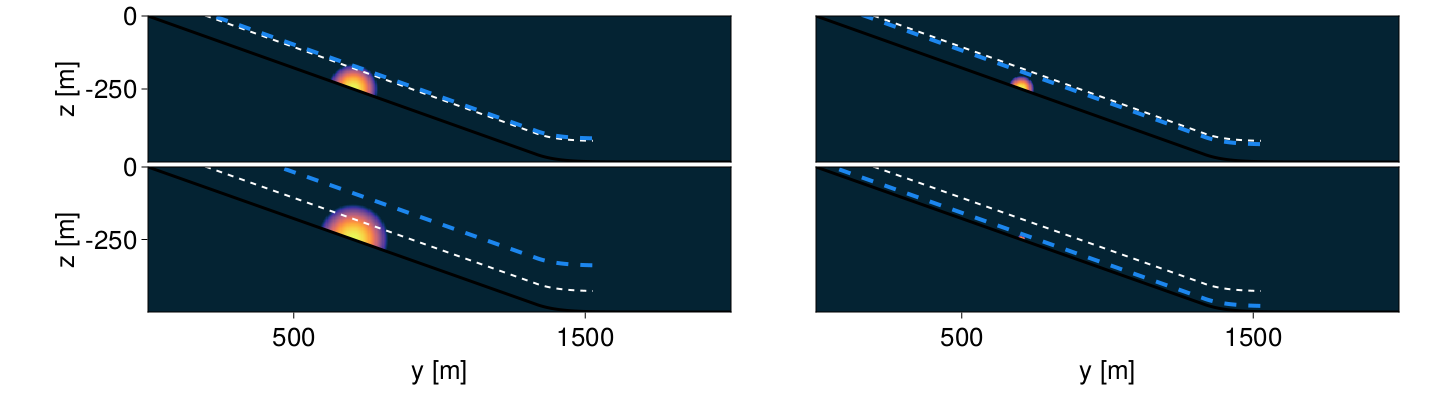

CairoMakie.Screen{IMAGE}


In [127]:
display(f)

In [131]:
Us= 0.05:0.05:0.55
δs = Us ./ pm.Ñ
stddev_ratio = 20 ./ δs
stddev4_ratio = 80 .- δs

65.71428571428572:-14.285714285714281:-77.1428571428571

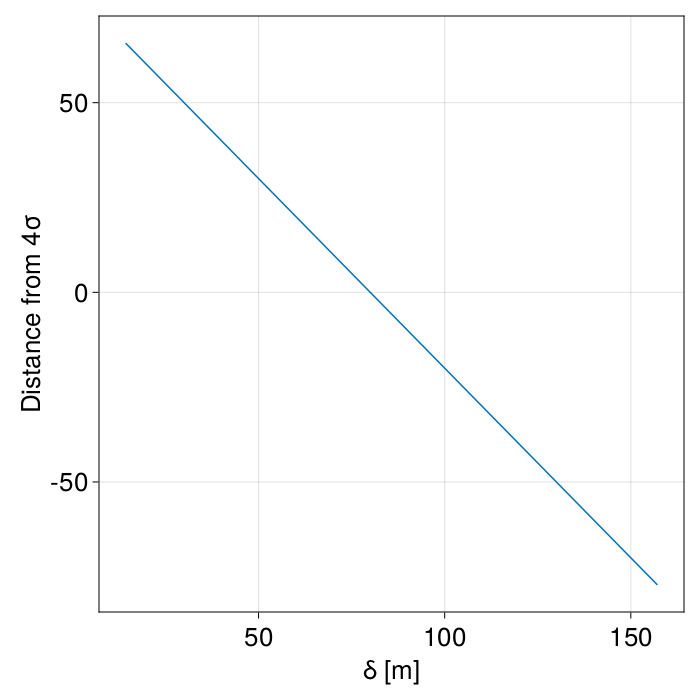

CairoMakie.Screen{IMAGE}


In [138]:
f = Figure(resolution = (700, 700),fontsize=26) 

ga = f[1, 1] = GridLayout()
axv = Axis(ga[1, 1], ylabel = "Distance from 4σ", xlabel = "δ [m]")

lines!(axv, δs, stddev4_ratio)

display(f)